# Neural network plays Conway's Game of Life

Cool, huh?

Not in the slightest! Both neural networks and Conway's Game of Life are instant buzzwords, but combining them, that's really stupid. How stupid? Consider that the weights of the neural network can be easily set by hand (as we will see).

No amount of stupidness should stop us from doing something interesting though. Who knows, maybe we will learn something new?

So in this notebook we:
 - Write down a neural network that plays the Game of Life.
 - Implement it with Torch.
 - Set it's weights by hand, so it perfectly emulates the rules of the game.
 - We train it to see how hard it is to train it to a perfect accuracy. Turns out, not that easy. 

And yes, stupidness is a real word.

![image.png](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

## Rules of the game
The [Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) is played in turns on a grid of square cells, which can be dead or alive. State of the cell on the next turn will be:
 - Alive, if it is dead and has three live neighbors.
 - Alive, if it is alive and has two or three live neighbors.
 - Dead otherwise.
 
Neighbors are the eight cells both side by side and diagonaly adjacent to the cell. These simple rules, applied every turn, produce wonderfully complex and chaotic patterns.

These rules are a natural "if else" algorithm that processes boolean values. It really makes no sense, from performance standpoint or otherwise, to replace them with a neural network, which is a comparably complicated chain of weighted sums and nonlinear functions on (typically) 64-bit floats.

We can write the rules as a function. The input will be a 3x3 array, containing 1s and 0s for live/dead cells, and output a 1 or 0 value for the center cell on the next turn. We could then apply this function to every 3x3 square on the grid on each turn to get the cell values for the next turn. This would definitely not be the most efficient implementation, but it's elegant, and as we will see, also usefull in our endeavor to misuse neural nets.

Here is such implementation of the rules, together with a function that generates all possible 3x3 squares (usefull for testing and training).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.metrics as mtr

np.set_printoptions(precision=2)

In [1]:
def conway_rule_straightforward(arr):
    center = arr[1,1]
    sum_perimeter = np.sum(arr) - center
    if (sum_perimeter == 3 and center == 0) or (sum_perimeter in (2,3) and center == 1):
        return 1
    else:
        return 0

def conway_rule(arr):
    """Equivalent to conway_rule_straightfoward, just more elegant. Check it for yourself!"""
    sum_total = np.sum(arr)
    sum_perimeter=sum_total - arr[1,1]
    if sum_total >= 3 and sum_perimeter <= 3:
        return 1
    else:
        return 0

In [3]:
def generate_neighborhoods():
    """Generate all possible 3x3 squares."""
    X=[]
    for i in range(2**9):
        x=[int(i) for i in format(i,"b")]    #turn binary string to list of integers
        x=[0 for i in range((9-len(x)))] + x    #pad with 0
        X.append(np.reshape(np.array(x),(3,3)))    #to array
    return np.array(X)

In [4]:
#example
x=generate_neighborhoods()[100]
y=conway_rule(x)
print(f"On the next turn, the centre cell of this square\n{x}\nwill have a value:\n{y}")

On the next turn, the centre cell of this square
[[0 0 1]
 [1 0 0]
 [1 0 0]]
will have a value:
1


In [80]:
#check if both implementations of the rules give the same results
for i in generate_neighborhoods():
    y1=conway_rule_straightforward(i)
    y2=conway_rule(i)
    if not y1==y2:
        print(f"Error on input:\n{i}\nconway_rule_straightforward: {y1}\nconway_rule: {y2}")
        break
else:
    print("Everything checks out!")

Everything checks out!


## How to turn this to a neural network?

The usual way of doing things is machine learning: we define the structure of the neural network and then we train it, that is, we use some algorithm (e.g. gradient descent) to tweak it's free parameters until its output resembles the desired one.

But we don't have to do that. Neural networks are just a special class of functions, like "quadratic functions" or "Fourier series" etc. We can just think really hard and write down its structure and parameters directly.

Here are a few insights that will help us do that:
 - We already implemented the rules as a function that takes a 3x3 square, which we can then apply to every such square on the grid. But that's exactly what convolutional neural networks do! So we are looking for a convolutional network with a 3x3 kernel.
 - A single neuron with two inputs can compute a logical AND function (or other logical functions, see [this page](https://towardsdatascience.com/perceptrons-logical-functions-and-the-xor-problem-37ca5025790a)).
 - We can exploit the symmetry of the rules. Rules are the same for every neighbor of the cell, their positions don't matter. The network can therefore also have this symmetry and all weights on the perimeter of the kernell can be the same (but don't necessary have to be).

Based on these, here is a neural network implementation of the rules. It's basically a direct rewrite of `conway_rule` function into a neural network. Keep in mind this implementation is not unique.

![image](image.png)

And that's it! Every time we apply this neural network to a grid, it will compute cell values for the next turn.

## Boundaries

The game should be played on an infinite grid. Since that would be quite complicated to implement, we instead opt for the finite grid which loops around: every cell on the edge is a neighbor to the corresponding cell on the opposite edge. This is also called periodic boundary conditions, and it's equivalent to having the grid not on a plane, but on a torus.

We achieve this looping around by simply padding the grid during the preprocessing step. We also make it optional, so when we turn the padding off and run the network on a 3x3 grid, the output is just the value for the center cell.

In [6]:
class ConwayStep(torch.nn.Module):
    """Neural network that computes a step of Conway's Game of Life. """
    def __init__(self,handcrafted=True):
        """If handcrafted is true, the handcrafted weights are used.
        Otherwise, the weights are initialised randomly."""
        
        super(ConwayStep,self).__init__()
        layer1=torch.nn.Conv2d(in_channels=1,   #because input from every cell is just one number, not a vector
                               out_channels=2,    #because middle layer has two neurons
                               stride=1,          #because we want the output for every cell
                               padding=0,         #because padding is done in preprocessing
                               kernel_size=(3,3))

        layer2=torch.nn.Conv2d(in_channels=2,     #because middle layer has two neurons
                               out_channels=1,     #because output is just one number: value for the center cell on the next turn
                               stride=1,
                               padding=0,
                               kernel_size=(1,1))
        
        if handcrafted:
            layer1.weight.data=torch.tensor([[[[-10.,-10.,-10.],
                                               [-10., 0.,-10.],
                                               [-10.,-10.,-10.]]],
                                             [[[10.,10.,10.],
                                               [10.,10.,10.],
                                               [10.,10.,10.]]]])
            layer1.bias.data=torch.tensor([40.,-20.])
            layer2.weight.data=torch.tensor([[[[50.]],[[50.]]]])
            layer2.bias.data=torch.tensor([-80.])

        self.network=torch.nn.Sequential(layer1,
                                         torch.nn.Sigmoid(),
                                         layer2,
                                         torch.nn.Sigmoid())
    
    def preprocess(self,batch,pad=False):
        """
        If pad is True, pads the array with the cells from the opposite edge, 
        so there are periodic boundary conditions.
        """
        if len(batch.shape)==2:
            batch=batch[None,:,:] #add empty dimension if only one sample is in the batch
        if pad:
            batch=np.pad(batch,pad_width=((0,0),(1,1),(1,1)),mode="wrap")
        return torch.Tensor(batch[:,None,:,:])   #add empty dimension for channels
    
    def postprocess(self,batch, threshold=0.5):
        """
        Applies thresholding (default threshold is 0.5)
        """
        batch=batch.detach().numpy()[:,0,:,:] #removes empty channels dimension
        batch=1*(batch > threshold)    #applies thresholding
        return batch.squeeze()   #remove empty dimensions

    def forward(self,x):
        return self.network(x)

In [7]:
net=ConwayStep()

In [8]:
#example
def show_grid(x):
    plt.pcolormesh(x, edgecolors='w', linewidth=2, cmap="Greens")
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.setp(ax.get_xticklabels(),  visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.show()
    
x=np.array([[0,0,0,0,0],
            [0,0,0,0,0],
            [0,1,1,1,0],
            [0,0,0,0,0],
            [0,0,0,0,0]])
print(f"Grid on current turn:\n\n{x}\n")

y_raw=net(net.preprocess(x,pad=True))
print(f"Output of the network before thresholding:\n\n{y_raw.detach().numpy()}\n")

y=net.postprocess(y_raw)
print(f"Grid on the next turn:\n\n{y}")


Grid on current turn:

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Output of the network before thresholding:

[[[[9.36e-14 9.36e-14 9.36e-14 9.36e-14 9.36e-14]
   [9.38e-14 6.69e-03 1.00e+00 6.69e-03 9.38e-14]
   [9.38e-14 6.69e-03 1.00e+00 6.69e-03 9.38e-14]
   [9.38e-14 6.69e-03 1.00e+00 6.69e-03 9.38e-14]
   [9.36e-14 9.36e-14 9.36e-14 9.36e-14 9.36e-14]]]]

Grid on the next turn:

[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]


In [81]:
#check if neural network gives the same results as the rules

X=generate_neighborhoods()
np.random.shuffle(X)
Y_label=np.array([conway_rule(i) for i in X])
Y_pred=net.postprocess(net(net.preprocess(X,pad=False)))

for x,label,prediction in zip(X,Y_label,Y_pred):
    if not label==prediction:
        print(f"Error on input:\n{x}\nconway_rule: {label}\nneural network: {prediction}\n")
        break
else:
    print("Everything checks out!")

Everything checks out!


# How to train the network

This is straightforward:
 - Our dataset will contain all possible 3x3 squares and labels will be generated by the conway_rule function, because that's all the data we may need.
 - Batch size will be 1 (online learning)
 - We will use crossentropy loss and Adam optimiser, because these two are rarely a bad choice.
 - The metrics of interest will be loss and the area under ROC curve (`roc_auc`) computed on the whole dataset at the end of each epoch. If the network achieves perfect accuracy, loss will be 0 and roc_auc 1. Loss alone is hard to interpret, since it can decrease even if the model accuracy doesn't improve.

At least that was the plan, but it turned out that it takes really, really long time for the network to converge, if it converges at all. Sometimes we got lucky and the network converged after a few hundred epochs, sometimes it got stuck for thousands of epochs, depending on the random initialisation. 

Turns out that Adam is not always the best choice. Somewhat surprisingly, ordinary stochastic gradiend descent with learning rate 0.01, converges reliably in 200 epochs. Stochastic gradient descent with momentum converges even faster.

In [13]:
net_trained=ConwayStep(handcrafted=False)

loss_func = torch.nn.BCELoss()

# this fails to converge
#optimizer = torch.optim.Adam(net_trained.parameters(),lr=0.01)
#num_epochs=5000

optimizer = torch.optim.SGD(net_trained.parameters(),lr=0.01,momentum=0.9,nesterov=True)
num_epochs=100

data=list(zip(X,Y_label))
batch_size=1

logs=[]
def detach_state_dict(state_dict):
    return {k:v.clone().detach().numpy() for k,v in state_dict.items()}    

for epoch in range(num_epochs):
    random.shuffle(data)
    for i,start in enumerate(range(len(data)//batch_size)):
        x,y_label=zip(*data[start:start+batch_size])

        # optimization
        optimizer.zero_grad()

        y_pred = net_trained(net_trained.preprocess(np.array(x)))
        loss = loss_func(y_pred, torch.tensor(y_label).type(torch.FloatTensor))
        loss.backward()
        
        optimizer.step()
        
    #logging, metrics and printing after each epoch
    with torch.no_grad():
        Y_pred=net_trained(net_trained.preprocess(X))
        loss=loss_func(Y_pred, torch.tensor(Y_label).type(torch.FloatTensor)).item()
        Y_pred=Y_pred.detach().numpy().squeeze()
        
    fpr,tpr,thresholds=mtr.roc_curve(Y_label,Y_pred)
    roc_auc=mtr.roc_auc_score(Y_label,Y_pred)
    print(f"epoch={epoch} loss={loss} roc_auc={roc_auc}")
    logs.append(dict(epoch=epoch,
                     fpr=fpr,
                     tpr=tpr,
                     thresholds=thresholds,
                     Y_pred=Y_pred,
                     loss=loss,
                     roc_auc=roc_auc,
                     state_dict=detach_state_dict(net_trained.state_dict())))
    plt.plot(fpr,tpr,label="roc")
    plt.plot(fpr,thresholds,".",label="thresholds")
    plt.legend()
    plt.show()

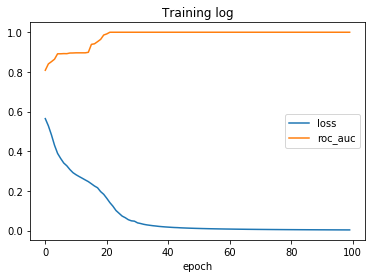

In [53]:
plt.title("Training log")
plt.plot([i["loss"] for i in logs],label="loss")
plt.plot([i["roc_auc"] for i in logs],label="roc_auc")
plt.xlabel("epoch")
plt.legend()
plt.show()

That's it. The trained neural network achieved perfect accuracy, since the area under ROC is 1. Conveniently, threshold 0.5 perfectly separates the classes, so we don't need to set it to a different value. Now we can just sit back and enjoy some inefficiently computed glider action.

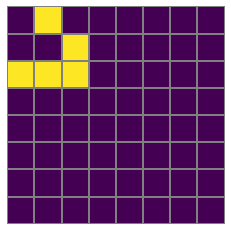

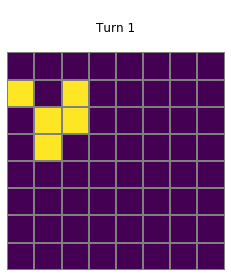

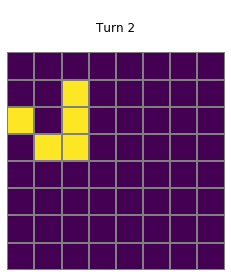

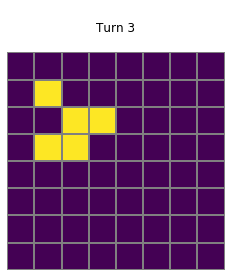

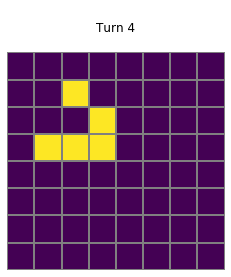

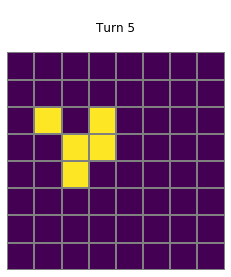

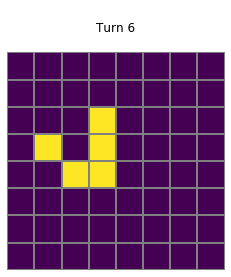

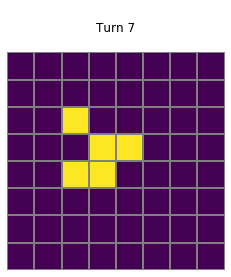

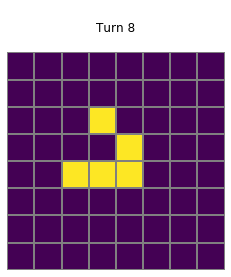

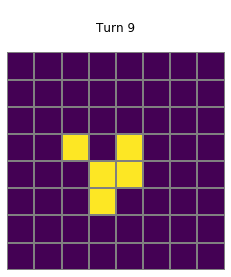

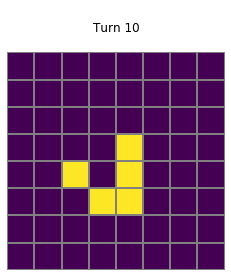

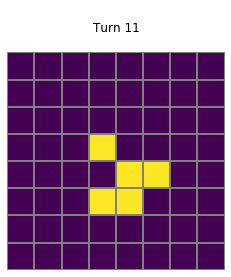

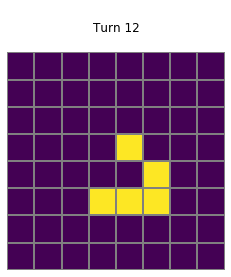

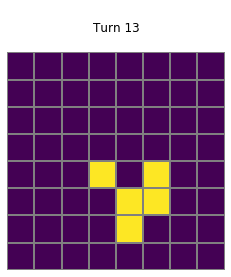

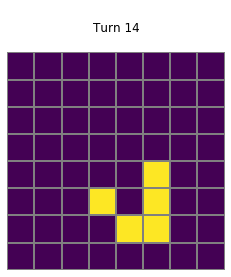

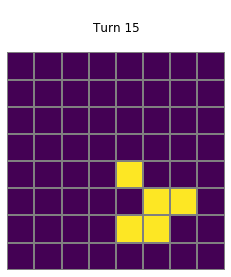

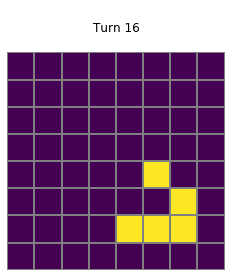

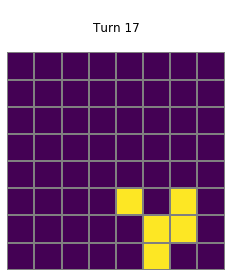

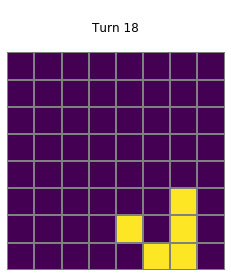

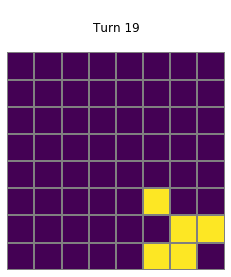

In [85]:
def show_grid(grid):
    plt.gca().set_xticks(np.arange(grid.shape[0]+1)-0.5,minor=True)
    plt.gca().set_yticks(np.arange(grid.shape[1]+1)-0.5,minor=True)
    plt.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    plt.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    for edge, spine in plt.gca().spines.items():
        spine.set_visible(False)
    plt.imshow(grid)
    plt.show()

glider=np.array([[0,1,0],
                 [0,0,1],
                 [1,1,1]])

grid=np.zeros((8,8))
grid[0:3,0:3]=glider
    
show_grid(grid)

for i in range(1,20):
    plt.title(f"\nTurn {i}\n")
    grid=net_trained.postprocess(net_trained(net_trained.preprocess(grid,pad=True)),threshold=0.1)
    show_grid(grid)


# Trained vs handcrafted

Here are the weights of the trained neural network.

In [61]:
net_trained.state_dict()

OrderedDict([('network.0.weight', tensor([[[[ 4.2063,  4.2074,  4.2075],
                        [ 4.2058,  0.2082,  4.2068],
                        [ 4.2066,  4.2060,  4.2068]]],
              
              
                      [[[-3.6498, -3.6486, -3.6481],
                        [-3.6492, -3.4376, -3.6488],
                        [-3.6483, -3.6495, -3.6493]]]])),
             ('network.0.bias', tensor([-15.2391,   8.6001])),
             ('network.2.weight', tensor([[[[-15.1833]],
              
                       [[-14.1411]]]])),
             ('network.2.bias', tensor([6.7846]))])

We can see that the trained network is remarkably simmilar to our handcrafted one. Next plot shows how weights of the network changed during training. Pay attention to the second channel of first layer (orange). During the second leap in accuracy, all weights in it converged to the same value, which broke the symmetry between channels and enabled the model to fit the data perfectly.

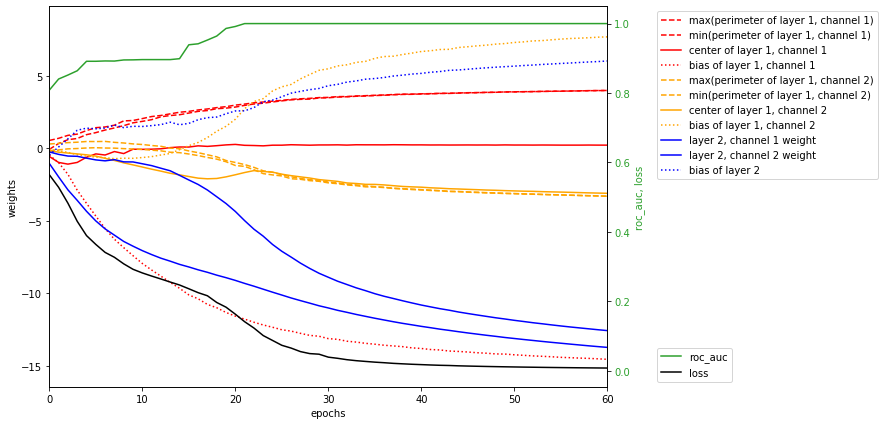

In [65]:
keys=["max(perimeter of layer 1, channel 1)",
       "min(perimeter of layer 1, channel 1)",
       "center of layer 1, channel 1",
       "bias of layer 1, channel 1",
       "max(perimeter of layer 1, channel 2)",
       "min(perimeter of layer 1, channel 2)",
       "center of layer 1, channel 2",
       "bias of layer 1, channel 2",
      "layer 2, channel 1 weight",
      "layer 2, channel 2 weight",
      "bias of layer 2"]

plots={k:[] for k in keys}

for record in logs:
    state_dict=record["state_dict"]
    
    weights=state_dict["network.0.weight"].squeeze()[0]
    perimeter=np.concatenate([weights[[0,2],:].ravel(),
                                weights[:,[0,2]].ravel()])
    plots[keys[0]].append(max(perimeter))
    plots[keys[1]].append(min(perimeter))
    plots[keys[2]].append(weights[1,1])
    plots[keys[3]].append(state_dict["network.0.bias"].squeeze()[0])
    
    weights=state_dict["network.0.weight"].squeeze()[1]
    perimeter=np.concatenate([weights[[0,2],:].ravel(),
                                weights[:,[0,2]].ravel()])
    plots[keys[4]].append(max(perimeter))
    plots[keys[5]].append(min(perimeter))
    plots[keys[6]].append(weights[1,1])
    plots[keys[7]].append(state_dict["network.0.bias"].squeeze()[1])
    
    plots[keys[8]].append(state_dict["network.2.weight"].squeeze()[0])
    plots[keys[9]].append(state_dict["network.2.weight"].squeeze()[1])
    plots[keys[10]].append(state_dict["network.2.bias"][0])

    
%matplotlib inline
plt.figure(figsize=(10,7))
for k,v in plots.items():
    if "perimeter" in k:
        linestyle="dashed"
    elif "bias" in k:
        linestyle='dotted'
    else:
        linestyle="solid"
    
    if "layer 1, channel 1" in k:
        color="red"
    elif "layer 1, channel 2" in k:
        color="orange"
    else:
        color="blue"
    plt.plot(v,color,label=k,linestyle=linestyle)

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left')    
plt.ylabel("weights")
plt.xlabel("epochs")
plt.xlim(0,60)

ax2=plt.gca().twinx()
color = 'tab:green'
ax2.set_ylabel('roc_auc, loss', color=color)
ax2.plot([i["roc_auc"] for i in logs], color=color, label= "roc_auc")
ax2.plot([i["loss"] for i in logs],"black",label="loss")
ax2.legend(bbox_to_anchor=(1.08, 0), loc='lower left')    
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

## Why Adam failed?

Short answer: I don't know yet.

Long answer:

The idea with neural networks and gradient descent is that the parameter space is usually high dimensional (one dimension for each weight or bias of a neural network). In high dimensional spaces, local minima are usually rare, since for a point to be a minimum, it must be a minimum in every direction. With e.g. 1000 dimensions, that's pretty unlikely, so gradient descent shoud have nowhere to get stuck.

But in our case, the network has just 23 parameters, and effectively even less. With Adam, network learned the symmetry of the data in just 100 epochs. Since then, all weights on the perimeter of the kernell were approximately the same, so in effect, our network had just 9 parameters. Usual assumptions about high dimensional spaces probably don't hold here.

My guess is therefore that Adam got stuck in some plateau or local minimum and was unable to move from it. It seemed to me that it usually failed to break the symmetry between the channels. But why that happened and why exactly pure SGD fared better is a good question, which definitely shows that it is indeed possible to learn something even from doing stupid things :)